In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import matplotlib
import logging

import utils as utils
from matplotlib import cm

In [2]:
runname = 'debug_withC_rogers_netcdfBdy1_EB_soliton_withsponge_focus_finey_summer'
datafilepath = '/Volumes/Tan_2024/SUNTANS/NLIW/iwave2024/dongsha/'+runname+'/data_f_1wave/'

# datafilename = 'sun_out.nc_0000.nc'
datafilename = 'sun_sparse.nc_0000.nc'

# path to saved result
resultfilepath = datafilepath+'/results/'
# path to saved figures
outfilepath = '../figure/'
if not os.path.exists(resultfilepath):
    os.mkdir(resultfilepath)
if not os.path.exists(outfilepath):
    os.mkdir(outfilepath)

param_data = {
    "datafilepath": datafilepath,
    "netcdf_filename": datafilename,
            }
param_result = {
    "resultfilepath": resultfilepath,
    "result_filename": 'sun_out_energy_derived.nc',
            }
idx_end = -15

# Read data

In [3]:
data = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_dissp.nc')
data_ = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'])

# Island center & Shoaling depth

In [4]:
lambdaM2=70.1e3
l_sponge = 20e3
L=1.5*lambdaM2+2*l_sponge
W=1.5*lambdaM2

x_c = 2*l_sponge+1.5*lambdaM2/2 
y_c = W/2

In [5]:
depth_top = 4
depth_shoal = 180
depth_bottom = 600-1e-2

# Section domain into circles & quadrants

In [6]:
# change to radial coordinate
dis_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        dis_c[i,j] = np.sqrt((data.x[i].data-x_c)**2+(data.y[j].data-y_c)**2)
        
theta_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        theta_c[i,j] = np.arctan2(data.y[j].data-y_c, data.x[i].data-x_c)

In [7]:
dis_top = np.mean(dis_c[np.where((data_.depth>=depth_top+.1) & (data_.depth.data<=depth_top+2))])
dis_shoal = np.mean(dis_c[np.where((data_.depth>=depth_shoal-1) & (data_.depth.data<=depth_shoal+1))])
dis_bottom = np.mean(dis_c[np.where((data_.depth>=depth_bottom-1) & (data_.depth.data<depth_bottom))])
quadrants_info = {
    "r_quad": np.array([dis_top, dis_shoal,dis_bottom]),
    "quadrants": ['east', 'north', 'west', 'south'],
    "theta_edge":np.array([-45, 45, 135, -135]),
    "theta_quad": [[-45, 45], [45, 135], [135, -135], [-135, -45]]
            }

In [8]:
# mask out data outside of the inner ring
mask_ring_inner = (dis_c>=quadrants_info["r_quad"][0]) & (dis_c<quadrants_info["r_quad"][1])
mask_ring_inner_east = mask_ring_inner & (theta_c>=quadrants_info["theta_quad"][0][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][0][1]*np.pi/180)
mask_ring_inner_north = mask_ring_inner & (theta_c>=quadrants_info["theta_quad"][1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][1][1]*np.pi/180)
mask_ring_inner_west = mask_ring_inner & ((theta_c>=quadrants_info["theta_quad"][2][0]*np.pi/180) | (theta_c<quadrants_info["theta_quad"][2][1]*np.pi/180))
mask_ring_inner_south = mask_ring_inner & (theta_c>=quadrants_info["theta_quad"][-1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][-1][1]*np.pi/180)

# mask out data outside of the outer ring
mask_ring_outer = (dis_c>=quadrants_info["r_quad"][1]) & (dis_c<quadrants_info["r_quad"][-1])
mask_ring_outer_east = mask_ring_outer & (theta_c>=quadrants_info["theta_quad"][0][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][0][1]*np.pi/180)
mask_ring_outer_north = mask_ring_outer & (theta_c>=quadrants_info["theta_quad"][1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][1][1]*np.pi/180)
mask_ring_outer_west = mask_ring_outer & ((theta_c>=quadrants_info["theta_quad"][2][0]*np.pi/180) | (theta_c<quadrants_info["theta_quad"][2][1]*np.pi/180))
mask_ring_outer_south = mask_ring_outer & (theta_c>=quadrants_info["theta_quad"][-1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][-1][1]*np.pi/180)

# Conversion

## overhead view

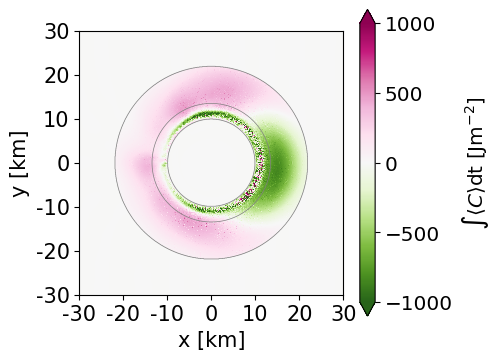

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = data_.C_int[-1,:,:].T.plot.pcolormesh(ax=ax, vmax=1e3, vmin=-1e3, cmap=cm.PiYG_r, add_colorbar=False)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle C\rangle$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"C_overhead_summer_f.jpeg", dpi=300)

## energy flux

In [22]:
# https://stackoverflow.com/questions/5328128/scipy-interpolation-of-large-matrix

def interp2d_nearest(X, Y, Z, x, y, spn=3, method='linear'):
    from scipy import interpolate
    xs,ys = map(np.array,(x,y))
    z = np.zeros(xs.shape)
    for i,(x,y) in enumerate(zip(xs,ys)):
        # get the indices of the nearest x,y
        xi = np.argmin(np.abs(X[0,:]-x))
        yi = np.argmin(np.abs(Y[:,0]-y))
        xlo = max(xi-spn, 0)
        ylo = max(yi-spn, 0)
        xhi = min(xi+spn, X[0,:].size)
        yhi = min(yi+spn, Y[:,0].size)
        # make slices of X,Y,Z that are only a few items wide
        nX = X.T[xlo:xhi, ylo:yhi]
        nY = Y.T[xlo:xhi, ylo:yhi]
        nZ = Z[xlo:xhi, ylo:yhi]
        intp = interpolate.interp2d(nX, nY, nZ, method)
        z[i] = intp(x,y)[0]
    return z


In [11]:
data_bc_fx = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bc_flux_x.nc')
data_bc_fy = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bc_flux_y.nc')

Fx_prime_int = data_bc_fx.Fx_prime1_int[-1,:,:].data+data_bc_fx.Fx_prime2_int[-1,:,:].data+data_bc_fx.Fx_prime3_int[-1,:,:].data+data_bc_fx.Fx_prime4_int[-1,:,:].data+data_bc_fx.Fx_prime5_int[-1,:,:].data
Fy_prime_int = data_bc_fy.Fy_prime1_int[-1,:,:].data+data_bc_fy.Fy_prime2_int[-1,:,:].data+data_bc_fy.Fy_prime3_int[-1,:,:].data+data_bc_fy.Fy_prime4_int[-1,:,:].data+data_bc_fy.Fy_prime5_int[-1,:,:].data
del data_bc_fx, data_bc_fy

In [12]:
data_bt_f = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bt_flux.nc')

Fx_0_int = data_bt_f.Fx_01_int[-1,:,:].data+data_bt_f.Fx_02_int[-1,:,:].data+data_bt_f.Fx_03_int[-1,:,:].data+data_bt_f.Fx_04_int[-1,:,:].data
Fy_0_int = data_bt_f.Fy_01_int[-1,:,:].data+data_bt_f.Fy_02_int[-1,:,:].data+data_bt_f.Fy_03_int[-1,:,:].data+data_bt_f.Fy_04_int[-1,:,:].data
del data_bt_f

In [23]:
[xv, yv] = np.meshgrid(data.x.data,data.y.data)
# del data, data_

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_68561/3655352027.py:19: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  intp = interpolate.interp2d(nX, nY, nZ, method)
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_68561/3655352027.py:20: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use 

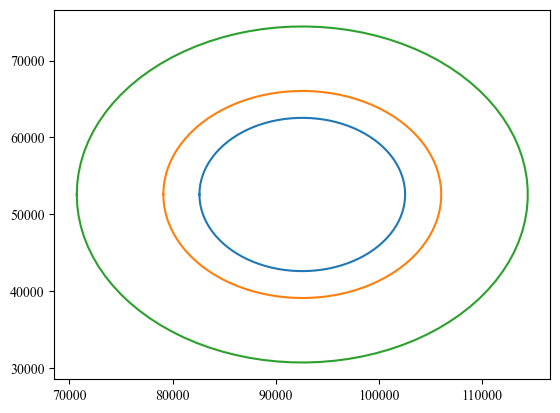

In [14]:
# interp F_prime onto rings and quadrants
x_circles = np.zeros((100, len(quadrants_info["r_quad"])))
y_circles = np.zeros((100, len(quadrants_info["r_quad"])))
Fx_prime_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
Fy_prime_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
Fx_0_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
Fy_0_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
# circles - small to big
theta_circles = np.linspace(-np.pi,np.pi,100)
for i in range(len(quadrants_info["r_quad"])):
    x_circles[:,i] = quadrants_info["r_quad"][i]*np.cos(theta_circles) + x_c
    y_circles[:,i] = quadrants_info["r_quad"][i]*np.sin(theta_circles) + y_c
    plt.plot(x_circles[:,i],y_circles[:,i])
    Fx_prime_int_ring[:,i] = interp2d_nearest(xv, yv, Fx_prime_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')
    Fy_prime_int_ring[:,i] = interp2d_nearest(xv, yv, Fy_prime_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')
    Fx_0_int_ring[:,i] = interp2d_nearest(xv, yv, Fx_0_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')
    Fy_0_int_ring[:,i] = interp2d_nearest(xv, yv, Fy_0_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_68561/3655352027.py:19: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  intp = interpolate.interp2d(nX, nY, nZ, method)
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_68561/3655352027.py:20: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use 

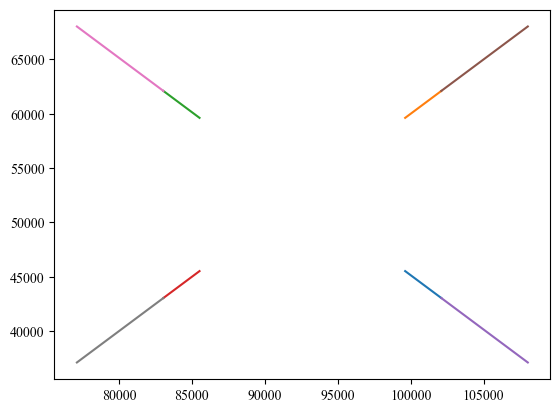

In [15]:
# interp F_prime onto rings and quadrants
x_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
y_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fx_prime_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fy_prime_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fx_0_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fy_0_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
# edges
for ii in range(len(quadrants_info["r_quad"])-1):
    r_edges = np.linspace(quadrants_info["r_quad"][ii],quadrants_info["r_quad"][ii+1],100)
    for i in range(len(quadrants_info["quadrants"])):
        x_edges[:,i,ii] = r_edges*np.cos(np.pi*quadrants_info["theta_edge"][i]/180) + x_c
        y_edges[:,i,ii] = r_edges*np.sin(np.pi*quadrants_info["theta_edge"][i]/180) + y_c
        plt.plot(x_edges[:,i,ii],y_edges[:,i,ii])
        Fx_prime_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fx_prime_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')
        Fy_prime_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fy_prime_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')
        Fx_0_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fx_0_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')
        Fy_0_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fy_0_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')

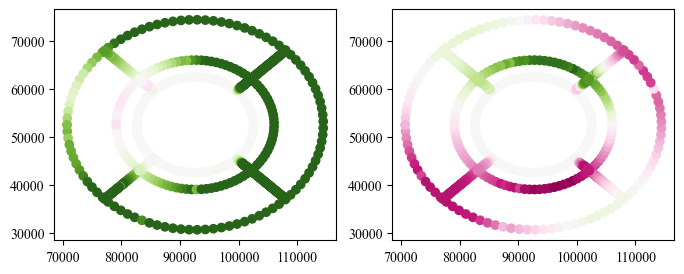

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

ax[0].scatter(x_circles, y_circles, c=Fx_prime_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[0].scatter(x_edges, y_edges, c=Fx_prime_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

ax[1].scatter(x_circles, y_circles, c=Fy_prime_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[1].scatter(x_edges, y_edges, c=Fy_prime_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

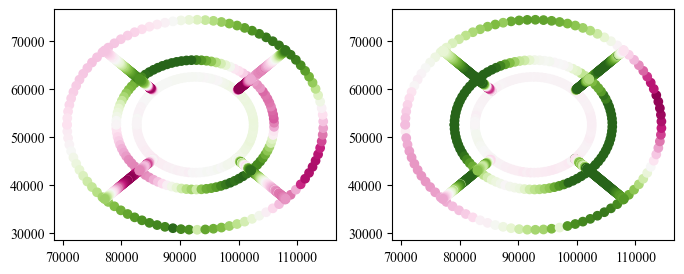

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

ax[0].scatter(x_circles, y_circles, c=Fx_0_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[0].scatter(x_edges, y_edges, c=Fx_0_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

ax[1].scatter(x_circles, y_circles, c=Fy_0_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[1].scatter(x_edges, y_edges, c=Fy_0_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

In [18]:
dissip0 = data.dissip0
dissip_prime = data.dissip_prime

# spatially filter dissipation; running mean, binsize = N
N = 10
dissip_prime_filter = dissip_prime[-1,:,:].data.copy()
dissip_0_filter = dissip0[-1,:,:].data.copy()
for i in range(len(data.x)):
    dissip_prime_filter[i,:] = np.convolve(dissip_prime_filter[i,:], np.ones(N)/N, 'same')
    dissip_0_filter[i,:] = np.convolve(dissip_0_filter[i,:], np.ones(N)/N, 'same')
for j in range(len(data.y)):
    dissip_prime_filter[:,j] = np.convolve(dissip_prime_filter[:,j], np.ones(N)/N, 'same')
    dissip_0_filter[:,j] = np.convolve(dissip_0_filter[:,j], np.ones(N)/N, 'same')

In [19]:
x_upstreams = [x_c+40e3, x_c+25e3]
x_downstreams = [x_c-40e3, x_c-25e3]

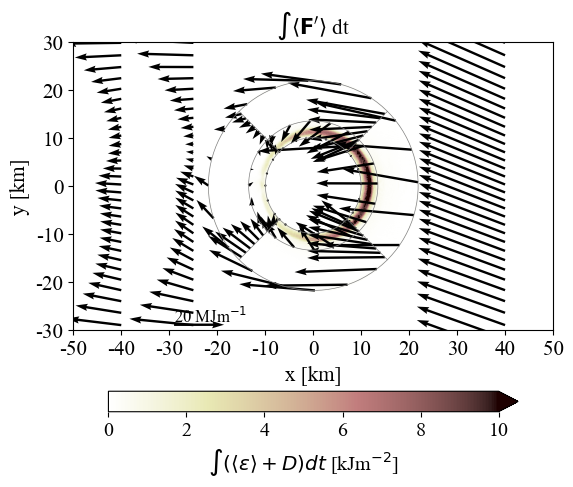

In [20]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
# im1 = (data.dissip0[-1,:,:]+data.dissip_prime[-1,:,:]).T.plot(ax=ax, vmax=1e4, vmin=0, cmap=cm.Reds, add_colorbar=False)
im1 = ax.pcolormesh(data.x.data, data.y.data, (dissip_prime_filter+dissip_0_filter).T, vmax=1e4, vmin=0, cmap=cm.pink_r)
cb1 = plt.colorbar(im1, shrink=0.8, location='bottom', extend='max', ticks=np.arange(0,1e4+1,2e3))
cb1.set_label(label=r"$\int(\langle\epsilon\rangle+D)dt$ [kJm$^{-2}$]", size='x-large')
cb1.ax.set_xticklabels(['0','2','4','6','8','10'])
cb1.ax.tick_params(labelsize='x-large')
ax.plot(x_circles,y_circles,c='grey',lw=.5)
idx_x = 1020
# ax.plot([data.x[idx_x],data.x[idx_x]],[data.y[0],data.y[-1]],'k',ls='--')
# ax.plot(data.x.data[idx_x], y_c-30000+500,'k^',markersize=10)
# ax.plot(data.x.data[idx_x], y_c+30000-500,'kv',markersize=10)
for ii in range(len(quadrants_info["r_quad"])-1):
    ax.plot(x_edges[:,:,ii],y_edges[:,:,ii],c='grey',lw=.5)
ax.quiver(x_circles[::5,:], y_circles[::5,:], Fx_prime_int_ring[::5,:], Fy_prime_int_ring[::5,:], scale=.4e+8, scale_units='inches', width=5e-3)
ax.quiver(x_edges[::25,:,0], y_edges[::25,:,0], Fx_prime_int_edges[::25,:,0], Fy_prime_int_edges[::25,:,0], scale=.4e+8, scale_units='inches', width=5e-3)
ax.quiver(x_edges[::15,:,1], y_edges[::15,:,1], Fx_prime_int_edges[::15,:,1], Fy_prime_int_edges[::15,:,1], scale=.4e+8, scale_units='inches', width=5e-3)
ax.quiver(x_c-30000+1000, y_c-30000+1000, .2e+8, 0, color='k', scale=.4e+8, scale_units='inches', width=5e-3)
ax.text(x_c-30000+1000, y_c-30000+1500,r'20 MJm$^{-1}$',color='k', fontsize=12)
# ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
# ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
# ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
x_upstream = x_upstreams[0]
ax.quiver(data.x.sel(x=x_upstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], Fy_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3)
# for x_upstream in x_upstreams:
#     ax.quiver(data.x.sel(x=x_upstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], Fy_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3)
for x_downstream in x_downstreams:
    ax.quiver(data.x.sel(x=x_downstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_prime_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], Fy_prime_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3)
ax.set_xlim([x_c-50000, x_c+50000])
# ax.set_ylim([y_c-50000, y_c+50000])
ax.set_xticks(np.arange(x_c-50000,x_c+50000+1,10000))
# ax.set_yticks(np.arange(y_c-50000,y_c+50000+1,10000))
ax.set_xticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
# ax.set_yticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])

ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(r"$\int\langle\mathbf{F'}\rangle$ dt", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"Fprime_dissp_int_summer_f.jpeg", dpi=300)

In [21]:
C_int = data_.C_int

# spatially filter dissipation; running mean, binsize = N
N = 10
C_int_filter = C_int[-1,:,:].data.copy()
for i in range(len(data.x)):
    C_int_filter[i,:] = np.convolve(C_int_filter[i,:], np.ones(N)/N, 'same')
for j in range(len(data.y)):
    C_int_filter[:,j] = np.convolve(C_int_filter[:,j], np.ones(N)/N, 'same')

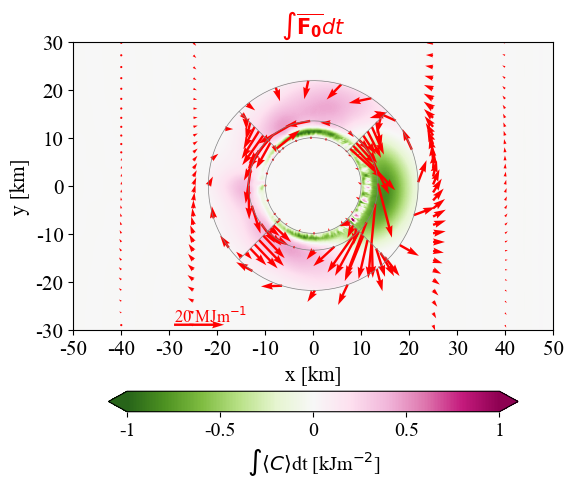

In [22]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
# im1 = data_.C_int[-1,:,:].T.plot(ax=ax, vmax=1e3, vmin=-1e3, cmap=cm.PiYG_r, add_colorbar=False)
im1 = ax.pcolormesh(data.x.data, data.y.data, C_int_filter.T, vmax=1e3, vmin=-1e3, cmap=cm.PiYG_r)
cb1 = plt.colorbar(im1, shrink=0.8, location='bottom', extend='both', ticks=np.arange(-1e3,1e3+1,5e2))
cb1.set_label(label=r"$\int\langle C\rangle$dt [kJm$^{-2}$]", size='x-large')
cb1.ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
cb1.ax.tick_params(labelsize='x-large')
ax.plot(x_circles,y_circles,c='grey',lw=.5)
idx_x = 1020
# ax.plot([data.x[idx_x],data.x[idx_x]],[data.y[0],data.y[-1]],'k',ls='--')
# ax.plot(data.x.data[idx_x], y_c-30000+500,'k^',markersize=10)
# ax.plot(data.x.data[idx_x], y_c+30000-500,'kv',markersize=10)
for ii in range(len(quadrants_info["r_quad"])-1):
    ax.plot(x_edges[:,:,ii],y_edges[:,:,ii],c='grey',lw=.5)
ax.quiver(x_circles[::5,:], y_circles[::5,:], Fx_0_int_ring[::5,:], Fy_0_int_ring[::5,:], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.quiver(x_edges[::25,:,0], y_edges[::25,:,0], Fx_0_int_edges[::25,:,0], Fy_0_int_edges[::25,:,0], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.quiver(x_edges[::15,:,1], y_edges[::15,:,1], Fx_0_int_edges[::15,:,1], Fy_0_int_edges[::15,:,1], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.quiver(x_c-30000+1000, y_c-30000+1000, .2e+8, 0, color='r', scale=.4e+8, scale_units='inches', width=5e-3)
ax.text(x_c-30000+1000, y_c-30000+1500,r'20 MJm$^{-1}$',color='r', fontsize=12)
# ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
# ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
# ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
for x_upstream in x_upstreams:
    ax.quiver(data.x.sel(x=x_upstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_0_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], Fy_0_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
for x_downstream in x_downstreams: 
    ax.quiver(data.x.sel(x=x_downstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_0_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], Fy_0_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.set_xlim([x_c-50000, x_c+50000])
# ax.set_ylim([y_c-50000, y_c+50000])
ax.set_xticks(np.arange(x_c-50000,x_c+50000+1,10000))
# ax.set_yticks(np.arange(y_c-50000,y_c+50000+1,10000))
ax.set_xticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
# ax.set_yticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title("$\int\overline{\mathbf{F_0}}dt$", fontsize=15, color='r')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"F0_C_int_summer_f.jpeg", dpi=300)

## time evolution

In [41]:
C = data_.C_int.differentiate("time",datetime_unit="s")
data["C"]=(['time', 'x', 'y'],  C.data)

In [24]:
C_inner = np.zeros((4, len(data.time)))
C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_east] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[0,:] = C_out_.integrate('y')

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_north] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[1,:] = C_out_.integrate('y')

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_west] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[2,:] = C_out_.integrate('y')

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_south] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[-1,:] = C_out_.integrate('y')

In [25]:
C_outer = np.zeros((4, len(data.time)))
C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_east] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[0,:] = C_out_.integrate('y')

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_north] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[1,:] = C_out_.integrate('y')

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_west] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[2,:] = C_out_.integrate('y')

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_south] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[-1,:] = C_out_.integrate('y')

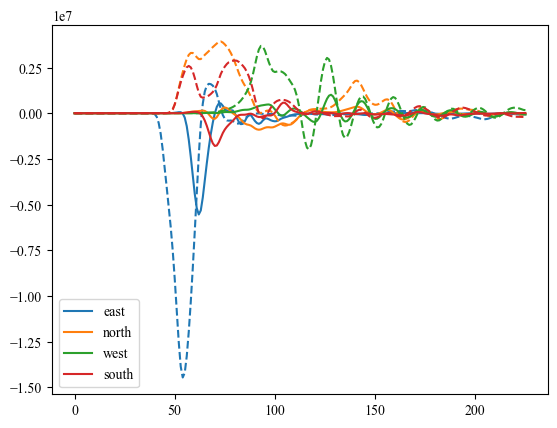

In [26]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(4):
    plt.plot(C_inner[i,:], c=colors[i], label=quadrants_info['quadrants'][i])
    plt.plot(C_outer[i,:], '--', c=colors[i])
plt.legend()

# Barotropic velocity

In [27]:
# read data
Data = xr.open_dataset(datafilepath+datafilename)

# grid info
import mat73
grid = mat73.loadmat('/Volumes/Tan_2024/SUNTANS/NLIW/iwave2024/dongsha/'+runname+'/mfiles/SUNTANS_grid.mat', only_include=['Nk', 'Nx', 'Ny', 'Depth', 'INPUT']) 

Nx = grid['Nx'].astype('int')
Ny = grid['Ny'].astype('int')
Nk = grid['Nk'].astype('int')
Nc = Nx*Ny
# Depth = np.reshape(grid['Depth'].astype('int'), (Nx, Ny), order='F')
Depth = np.reshape(grid['Depth'], (Nx, Ny), order='F')

xv = np.reshape(Data.xv.data, (Nx, Ny), order='F')
yv = np.reshape(Data.yv.data, (Nx, Ny), order='F')

In [28]:
U = np.reshape(Data.Ubt.data, (len(Data.time), Nx, Ny), order='F')
V = np.reshape(Data.Vbt.data, (len(Data.time), Nx, Ny), order='F')
del Data

## transform to cylindrical coordinates

In [13]:
def cart_to_cyl(u,v,theta):
    """ this function transforms a cartesian vector u,v to cylindrical coordinates u_r, u_theta, with angle theta (rad)
    """
    u_r = u * np.cos(theta) + v * np.sin(theta)
    u_theta = -u * np.sin(theta) + v * np.cos(theta)
    return u_r, u_theta

In [30]:
# transform to cylindrical coordinates
U_r = np.zeros(U.shape) + np.nan
U_theta = np.zeros(U.shape) + np.nan
for i in range(U.shape[0]):
    U_r[i,:,:], U_theta[i,:,:] = cart_to_cyl(U[i,:,:], V[i,:,:], theta_c)

## time-integration

In [31]:
data["U_r"]=(['time', 'x', 'y'],  U_r)
data["U_theta"]=(['time', 'x', 'y'],  U_theta)

In [32]:
U_r_int = data.U_r.integrate('time',datetime_unit="s")
U_theta_int = data.U_theta.integrate('time',datetime_unit="s")

## overhead view

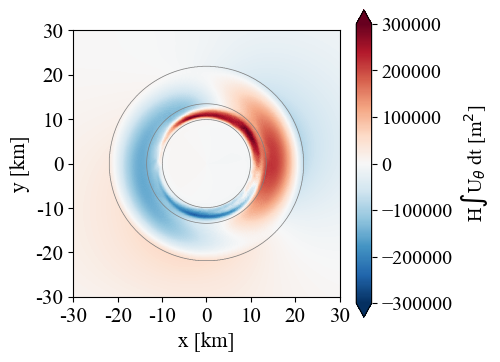

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = (U_theta_int*data_.depth).T.plot.pcolormesh(ax=ax, vmax=3e5, vmin=-3e5, cmap=cm.RdBu_r, add_colorbar=False)
# im1 = U_theta_int.T.plot.pcolormesh(ax=ax, vmax=5e3, vmin=-5e3, cmap=cm.RdBu_r, add_colorbar=False)
# im1 = ax.pcolormesh(data.x.data, data.y.data, U_r[40,:,:].T, vmax=1e-1, vmin=-1e-1, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
# cb1.set_label(label=r"U [ms$^{-1}$]", size='x-large')
# cb1.set_label(label=r"$\int$U$_\theta$ dt [m]", size='x-large')
cb1.set_label(label=r"H$\int$U$_\theta$ dt [m$^2$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

# plt.savefig(outfilepath+ f"U_theta_int_overhead_summer_f.jpeg", dpi=300)
plt.savefig(outfilepath+ f"UH_theta_int_overhead_summer_f.jpeg", dpi=300)

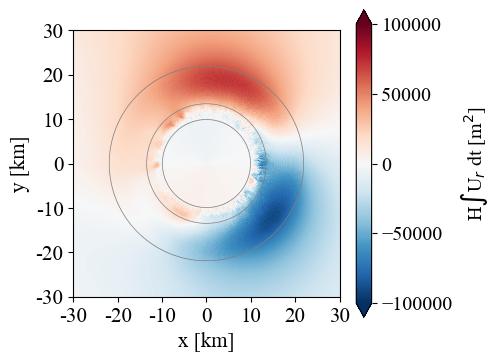

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = (U_r_int*data_.depth).T.plot.pcolormesh(ax=ax, vmax=1e5, vmin=-1e5, cmap=cm.RdBu_r, add_colorbar=False)
# im1 = U_r_int.T.plot.pcolormesh(ax=ax, vmax=1e3, vmin=-1e3, cmap=cm.RdBu_r, add_colorbar=False)
# im1 = ax.pcolormesh(data.x.data, data.y.data, U_r[40,:,:].T, vmax=1e-1, vmin=-1e-1, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
# cb1.set_label(label=r"U [ms$^{-1}$]", size='x-large')
# cb1.set_label(label=r"$\int$U$_r$ dt [m]", size='x-large')
cb1.set_label(label=r"H$\int$U$_r$ dt [m$^2$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

# plt.savefig(outfilepath+ f"U_r_int_overhead_summer_f.jpeg", dpi=300)
plt.savefig(outfilepath+ f"UH_r_int_overhead_summer_f.jpeg", dpi=300)

## time evolution
of momentum U*H

### UH_r

In [35]:
UH_r_inner = np.zeros((4, len(data.time)))
U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_east] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_inner[0,:] = U_r_out_.integrate('y')

U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_north] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_inner[1,:] = U_r_out_.integrate('y')

U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_west] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_inner[2,:] = U_r_out_.integrate('y')

U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_south] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_inner[-1,:] = U_r_out_.integrate('y')

In [36]:
UH_r_outer = np.zeros((4, len(data.time)))
U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_east] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_outer[0,:] = U_r_out_.integrate('y')

U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_north] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_outer[1,:] = U_r_out_.integrate('y')

U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_west] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_outer[2,:] = U_r_out_.integrate('y')

U_r_ = np.abs(data.U_r.copy())
for i in range(len(U_r_.time)):
    var_ = U_r_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_south] = 0
    U_r_[i,:,:] = var_
U_r_out_ = U_r_.integrate('x')
UH_r_outer[-1,:] = U_r_out_.integrate('y')

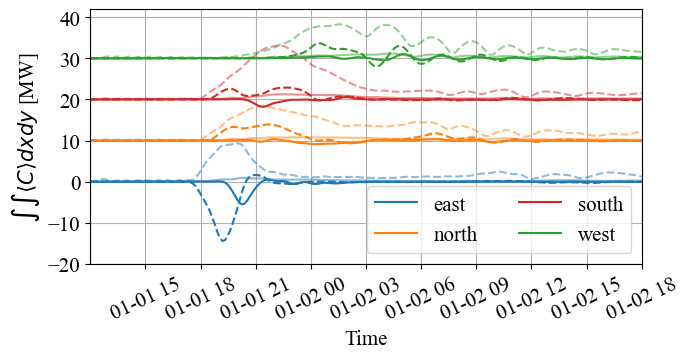

In [37]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.7))
count=0
for i in [0,1,3,2]:
    plt.plot(data.time, C_inner[i,:]*1e-6+count*10, c=colors[i], label=quadrants_info['quadrants'][i])
    plt.plot(data.time, C_outer[i,:]*1e-6+count*10, '--', c=colors[i])
    plt.plot(data.time, np.abs(UH_r_inner[i,:])*1e-8+count*10, c=colors[i], alpha=.5)
    plt.plot(data.time, np.abs(UH_r_outer[i,:])*1e-8+count*10, '--', c=colors[i], alpha=.5)
    count+=1
ax.set_xlim([data.time[0].data,data.time[-1].data])
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel(r"$\int\int\langle C\rangle dxdy$ [MW]", fontsize=15)
ax.set_yticks(np.arange(-20,40+1e-4,10))
ax.set_ylim([-20,42])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 25)
ax.set_title('')
ax.grid()
ax.legend(fontsize=15, ncol=2, loc='lower right')

plt.tight_layout()
plt.savefig(outfilepath+ f"C_and_UHr_areaintegrate_quadrants_circlebreakdown_summer_f.jpeg", dpi=300)

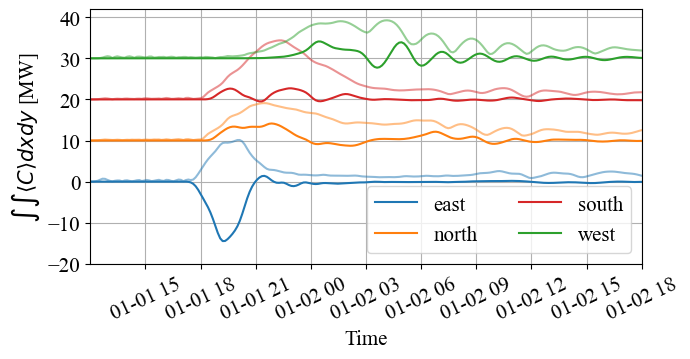

In [38]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.7))
count=0
for i in [0,1,3,2]:
    plt.plot(data.time, C_inner[i,:]*1e-6+C_outer[i,:]*1e-6+count*10, c=colors[i], label=quadrants_info['quadrants'][i])
    plt.plot(data.time, np.abs(UH_r_inner[i,:]+UH_r_outer[i,:])*1e-8+count*10, c=colors[i], alpha=.5)
    count+=1
ax.set_xlim([data.time[0].data,data.time[-1].data])
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel(r"$\int\int\langle C\rangle dxdy$ [MW]", fontsize=15)
ax.set_yticks(np.arange(-20,40+1e-4,10))
ax.set_ylim([-20,42])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 25)
ax.set_title('')
ax.grid()
ax.legend(fontsize=15, ncol=2, loc='lower right')

plt.tight_layout()
plt.savefig(outfilepath+ f"C_and_UHr_areaintegrate_quadrants_allcircle_summer_f.jpeg", dpi=300)

### UH_theta

In [39]:
UH_theta_inner = np.zeros((4, len(data.time)))
U_theta_ = np.abs(data.U_theta.copy())
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_east] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_inner[0,:] = U_theta_out_.integrate('y')

U_theta_ = np.abs(data.U_theta.copy())
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_north] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_inner[1,:] = U_theta_out_.integrate('y')

U_theta_ = np.abs(data.U_theta.copy())
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_west] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_inner[2,:] = U_theta_out_.integrate('y')

U_theta_ = np.abs(data.U_theta.copy())
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_inner_south] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_inner[-1,:] = U_theta_out_.integrate('y')

In [40]:
UH_theta_outer = np.zeros((4, len(data.time)))
U_theta_ = data.U_theta.copy()
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_east] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_outer[0,:] = U_theta_out_.integrate('y')

U_theta_ = np.abs(data.U_theta.copy())
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_north] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_outer[1,:] = U_theta_out_.integrate('y')

U_theta_ = np.abs(data.U_theta.copy())
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_west] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_outer[2,:] = U_theta_out_.integrate('y')

U_theta_ = np.abs(data.U_theta.copy())
for i in range(len(U_theta_.time)):
    var_ = U_theta_[i,:,:].data*data_.depth.data
    var_[~mask_ring_outer_south] = 0
    U_theta_[i,:,:] = var_
U_theta_out_ = U_theta_.integrate('x')
UH_theta_outer[-1,:] = U_theta_out_.integrate('y')

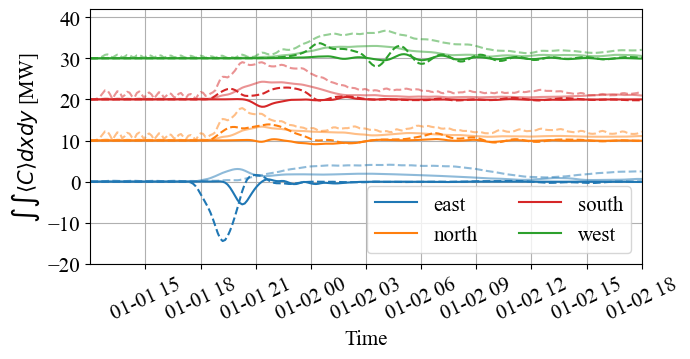

In [41]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.7))
count=0
for i in [0,1,3,2]:
    plt.plot(data.time, C_inner[i,:]*1e-6+count*10, c=colors[i], label=quadrants_info['quadrants'][i])
    plt.plot(data.time, C_outer[i,:]*1e-6+count*10, '--', c=colors[i])
    plt.plot(data.time, np.abs(UH_theta_inner[i,:])*1e-8+count*10, c=colors[i], alpha=.5)
    plt.plot(data.time, np.abs(UH_theta_outer[i,:])*1e-8+count*10, '--', c=colors[i], alpha=.5)
    count+=1
ax.set_xlim([data.time[0].data,data.time[-1].data])
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel(r"$\int\int\langle C\rangle dxdy$ [MW]", fontsize=15)
ax.set_yticks(np.arange(-20,40+1e-4,10))
ax.set_ylim([-20,42])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 25)
ax.set_title('')
ax.grid()
ax.legend(fontsize=15, ncol=2, loc='lower right')

plt.tight_layout()
plt.savefig(outfilepath+ f"C_and_UHtheta_areaintegrate_quadrants_circlebreakdown_summer_f.jpeg", dpi=300)

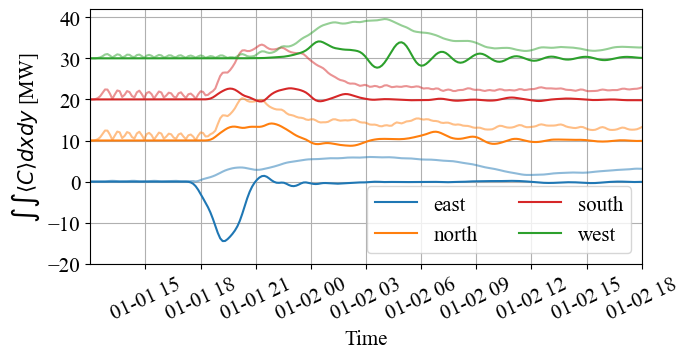

In [42]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.7))
count=0
for i in [0,1,3,2]:
    plt.plot(data.time, C_inner[i,:]*1e-6+C_outer[i,:]*1e-6+count*10, c=colors[i], label=quadrants_info['quadrants'][i])
    plt.plot(data.time, np.abs(UH_theta_inner[i,:]+UH_theta_outer[i,:])*1e-8+count*10, c=colors[i], alpha=.5)
    count+=1
ax.set_xlim([data.time[0].data,data.time[-1].data])
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel(r"$\int\int\langle C\rangle dxdy$ [MW]", fontsize=15)
ax.set_yticks(np.arange(-20,40+1e-4,10))
ax.set_ylim([-20,42])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 25)
ax.set_title('')
ax.grid()
ax.legend(fontsize=15, ncol=2, loc='lower right')

plt.tight_layout()
plt.savefig(outfilepath+ f"C_and_UHtheta_areaintegrate_quadrants_allcircle_summer_f.jpeg", dpi=300)

# BC/BT fluxes

## int(F(t))

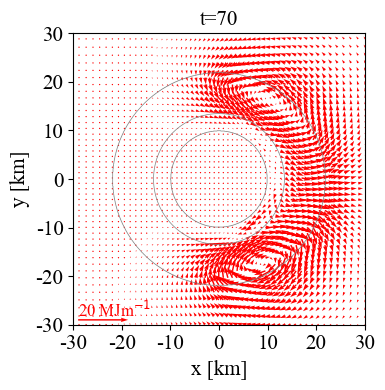

In [71]:
data_bt_f = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bt_flux.nc')

idx_t = 70

Fx_0_int_idx_t = data_bt_f.Fx_01_int[idx_t,:,:].data+data_bt_f.Fx_02_int[idx_t,:,:].data+data_bt_f.Fx_03_int[idx_t,:,:].data+data_bt_f.Fx_04_int[idx_t,:,:].data
Fy_0_int_idx_t = data_bt_f.Fy_01_int[idx_t,:,:].data+data_bt_f.Fy_02_int[idx_t,:,:].data+data_bt_f.Fy_03_int[idx_t,:,:].data+data_bt_f.Fy_04_int[idx_t,:,:].data

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
# im1 = ax.pcolormesh(data.x.data, data.y.data, Fx_0_int_idx_t.T, vmax=1e7, vmin=-1e7, cmap=cm.RdBu_r)
# cb1 = plt.colorbar(im1, location='right', extend='both')
# cb1.set_label(label=r"$\int\langle F_{0x}\rangle$dt [Jm$^{-2}$]", size='x-large')
ax.quiver(data.x.data[::20], data.y.data[::20], Fx_0_int_idx_t[::20,::20].T, Fy_0_int_idx_t[::20,::20].T, scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.quiver(x_c-30000+1000, y_c-30000+1000, .2e+8, 0, color='r', scale=.4e+8, scale_units='inches', width=5e-3)
ax.text(x_c-30000+1000, y_c-30000+1500,r'20 MJm$^{-1}$',color='r', fontsize=12)
# ax.quiver(data.x.data[::20], data.y.data[::20], Fx_0_int_idx_t[::20,::20].T, Fy_0_int_idx_t[::20,::20].T, scale=.1e+8, scale_units='inches', width=5e-3, color='r')
# ax.quiver(x_c-30000+1000, y_c-30000+1000, .1e+8, 0, color='r', scale=.1e+8, scale_units='inches', width=5e-3)
# ax.text(x_c-30000+1000, y_c-30000+1500,r'10 MJm$^{-1}$',color='r', fontsize=12)
# cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f't={idx_t}', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

## F(t)

In [6]:
data_f=xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_flux.nc')

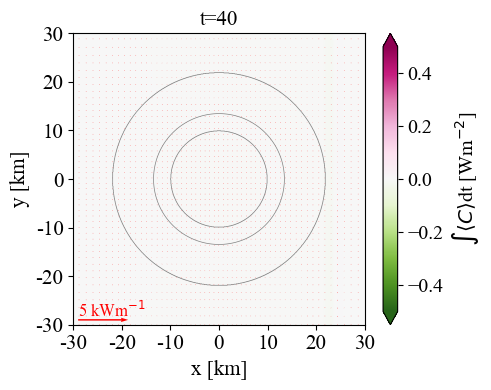

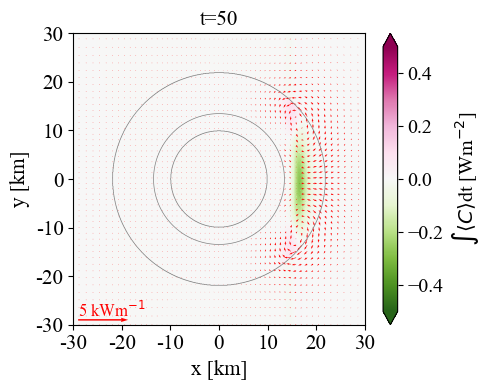

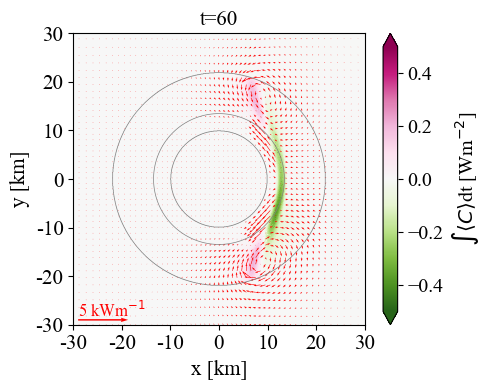

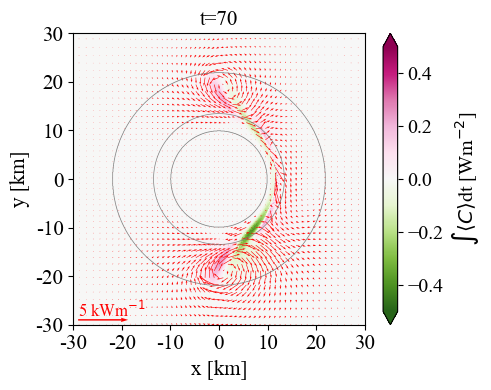

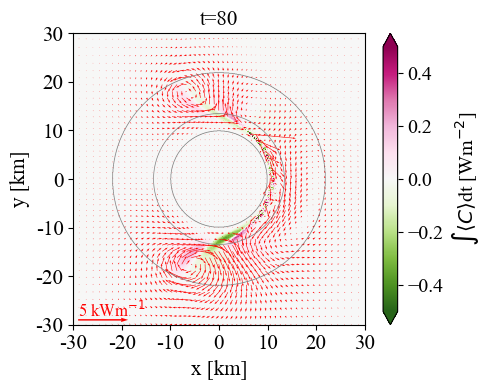

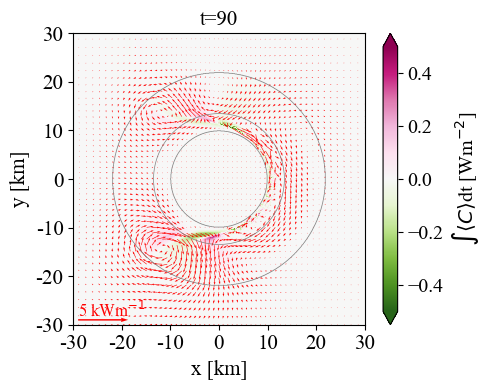

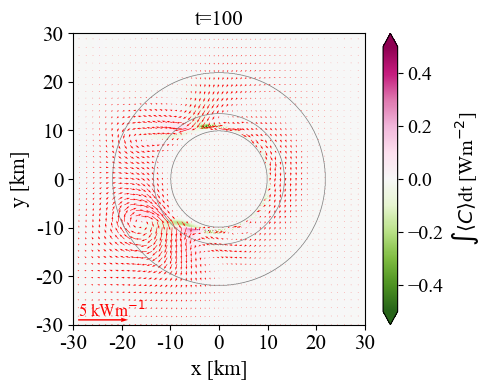

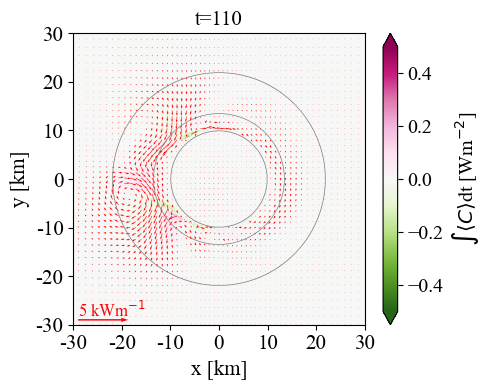

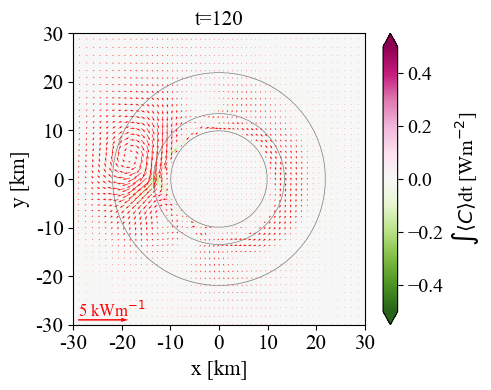

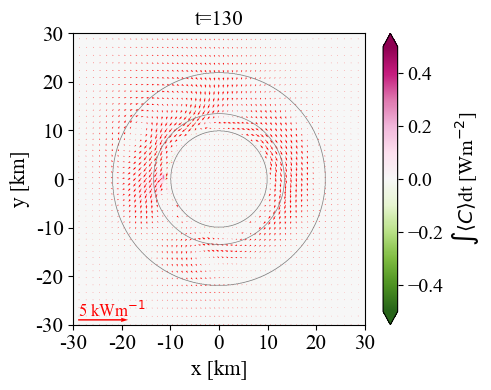

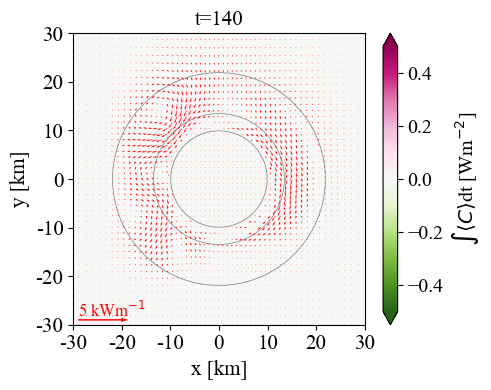

In [68]:
for idx_t in np.arange(40,140+1,10):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
    im1 = data.C[idx_t,:,:].T.plot.pcolormesh(ax=ax, vmax=.5, vmin=-.5, cmap=cm.PiYG_r, add_colorbar=False)
    cb1 = plt.colorbar(im1, location='right', extend='both')
    cb1.set_label(label=r"$\int\langle C\rangle$dt [Wm$^{-2}$]", size='x-large')
    cb1.ax.tick_params(labelsize='x-large')
    ax.quiver(data.x.data[::20], data.y.data[::20], data_f.Fx_0.data[idx_t,::20,::20].T, data_f.Fy_0.data[idx_t,::20,::20].T, scale=1e+4, scale_units='inches', width=2e-3, color='r')
    ax.quiver(x_c-30000+1000, y_c-30000+1000, .5e+4, 0, color='r', scale=1e+4, scale_units='inches', width=5e-3)
    ax.text(x_c-30000+1000, y_c-30000+1500,r'5 kWm$^{-1}$',color='r', fontsize=12)
    # cb1.ax.tick_params(labelsize='x-large')
    ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)
    
    ax.set_xlim([x_c-30000, x_c+30000])
    ax.set_ylim([y_c-30000, y_c+30000])
    ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
    ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
    ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
    ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
    # ax.set_xlim([x_c-50000, x_c+50000])
    # ax.set_ylim([y_c-50000, y_c+50000])
    # ax.set_xticks(np.arange(x_c-50000,x_c+50000+1,10000))
    # ax.set_yticks(np.arange(y_c-50000,y_c+50000+1,10000))
    # ax.set_xticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
    # ax.set_yticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
    ax.set_aspect('equal')

    ax.set_xlabel('x [km]', fontsize=15)
    ax.set_ylabel('y [km]', fontsize=15)
    ax.set_title(f't={idx_t}', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.tight_layout()
        
    plt.savefig(outfilepath+ f"F0_overhead_summer_f_t{idx_t}.jpeg", dpi=300)

# Reflection

In [8]:
x_upstreams = [x_c+40e3, x_c+25e3]
x_downstreams = [x_c-40e3, x_c-25e3]

In [11]:
data_f = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_flux.nc')

## transform to cylindrical coordinates

In [14]:
# transform to cylindrical coordinates
Fr_0 = np.zeros(data_f.Fx_0.data.shape) + np.nan
Ftheta_0 = np.zeros(data_f.Fx_0.data.shape) + np.nan
for i in range(data_f.Fx_0.data.shape[0]):
    Fr_0[i,:,:], Ftheta_0[i,:,:] = cart_to_cyl(data_f.Fx_0[i,:,:], data_f.Fy_0[i,:,:], theta_c)

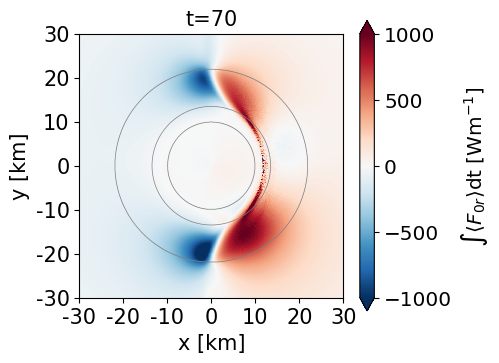

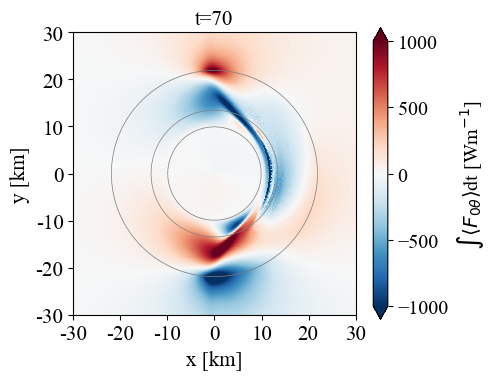

In [15]:
idx_t = 70

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = plt.pcolormesh(data.x.data, data.y.data, Fr_0[idx_t,:,:].T, vmax=1e3, vmin=-1e3, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle F_{0r}\rangle$dt [Wm$^{-1}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_aspect('equal')

ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f't={idx_t}', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = plt.pcolormesh(data.x.data, data.y.data, Ftheta_0[idx_t,:,:].T, vmax=1e3, vmin=-1e3, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle F_{0 \theta}\rangle$dt [Wm$^{-1}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_aspect('equal')

ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f't={idx_t}', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()


In [16]:
# transform to cylindrical coordinates
Fr_prime = np.zeros(data_f.Fx_prime.data.shape) + np.nan
Ftheta_prime = np.zeros(data_f.Fx_prime.data.shape) + np.nan
for i in range(data_f.Fx_prime.data.shape[0]):
    Fr_prime[i,:,:], Ftheta_prime[i,:,:] = cart_to_cyl(data_f.Fx_prime[i,:,:], data_f.Fy_prime[i,:,:], theta_c)

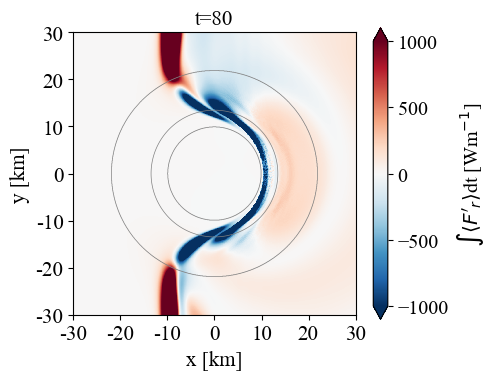

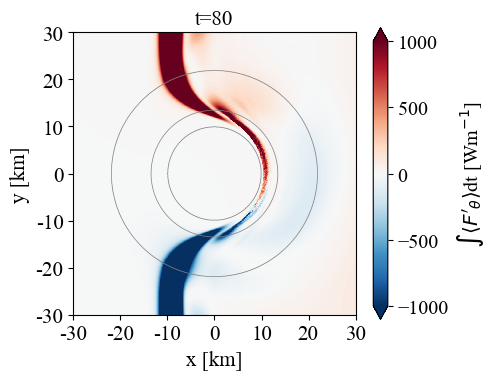

In [21]:
idx_t = 80

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = plt.pcolormesh(data.x.data, data.y.data, Fr_prime[idx_t,:,:].T, vmax=1e3, vmin=-1e3, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle F'_r\rangle$dt [Wm$^{-1}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_aspect('equal')

ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f't={idx_t}', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = plt.pcolormesh(data.x.data, data.y.data, Ftheta_prime[idx_t,:,:].T, vmax=1e3, vmin=-1e3, cmap=cm.RdBu_r)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle F'_\theta\rangle$dt [Wm$^{-1}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_aspect('equal')

ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f't={idx_t}', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()


## calculate reflectance

In [61]:
reflectance_info = {
    "r_reflect": np.array([dis_bottom,dis_bottom+10e3,dis_bottom+20e3]),
            }

In [62]:
[xv, yv] = np.meshgrid(data_f.x.data,data_f.y.data)

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_93237/3655352027.py:19: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  intp = interpolate.interp2d(nX, nY, nZ, method)
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_93237/3655352027.py:20: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use 

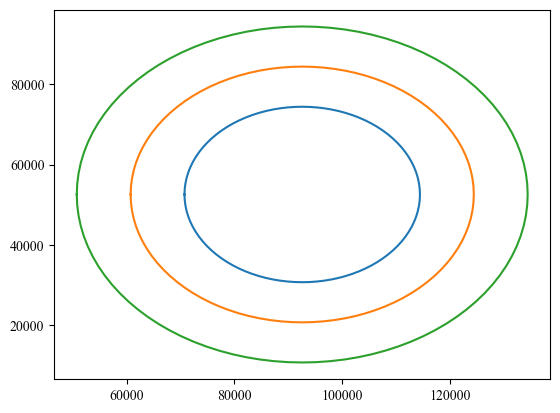

In [63]:
# interp F_prime onto rings and quadrants
x_circles = np.zeros((101, len(reflectance_info["r_reflect"])))
y_circles = np.zeros((101, len(reflectance_info["r_reflect"])))
Fr_0_ring = np.zeros((len(data_f.time.data), 101, len(reflectance_info["r_reflect"])))
Fr_prime_ring = np.zeros((len(data_f.time.data), 101, len(reflectance_info["r_reflect"])))
# circles - small to big
theta_circles = np.linspace(-np.pi,np.pi,101)
for i in range(len(reflectance_info["r_reflect"])):
    x_circles[:,i] = reflectance_info["r_reflect"][i]*np.cos(theta_circles) + x_c
    y_circles[:,i] = reflectance_info["r_reflect"][i]*np.sin(theta_circles) + y_c
    plt.plot(x_circles[:,i],y_circles[:,i])
    for idx_t in range(len(data_f.time.data)):
        Fr_0_ring[idx_t,:,i] = interp2d_nearest(xv, yv, Fr_0[idx_t,:,:], x_circles[:,i], y_circles[:,i], spn=3, method='linear')
        Fr_prime_ring[idx_t,:,i] = interp2d_nearest(xv, yv, Fr_prime[idx_t,:,:], x_circles[:,i], y_circles[:,i], spn=3, method='linear')

(-1000.0, 1000.0)

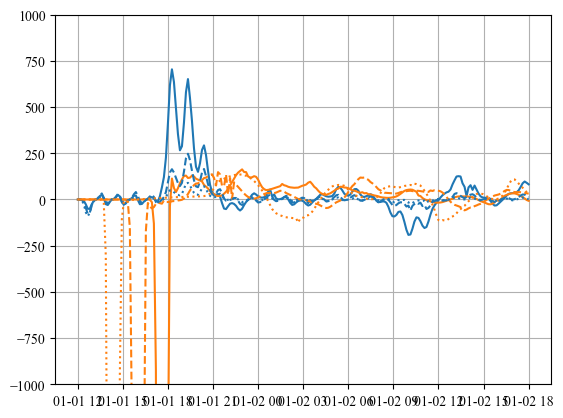

In [64]:
plt.plot(data_f.time,Fr_0_ring[:,50,0],c='tab:blue')
plt.plot(data_f.time,Fr_prime_ring[:,50,0],c='tab:orange')
plt.plot(data_f.time,Fr_0_ring[:,50,1],'--',c='tab:blue')
plt.plot(data_f.time,Fr_prime_ring[:,50,1],'--',c='tab:orange')
plt.plot(data_f.time,Fr_0_ring[:,50,-1],':',c='tab:blue')
plt.plot(data_f.time,Fr_prime_ring[:,50,-1],':',c='tab:orange')

plt.grid(True)
plt.ylim([-1000,1000])

(-1000.0, 1000.0)

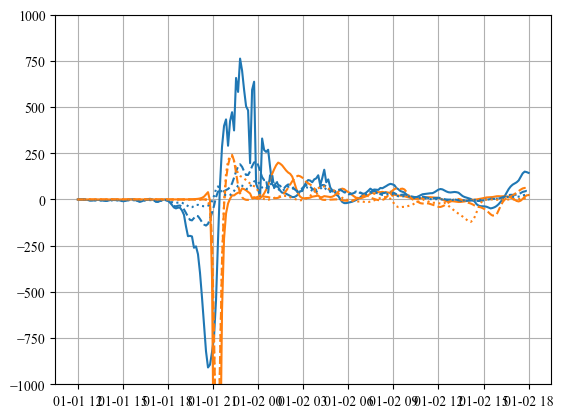

In [100]:
plt.plot(data_f.time,Fr_0_ring[:,25,0],c='tab:blue')
plt.plot(data_f.time,Fr_prime_ring[:,25,0],c='tab:orange')
plt.plot(data_f.time,Fr_0_ring[:,25,1],'--',c='tab:blue')
plt.plot(data_f.time,Fr_prime_ring[:,25,1],'--',c='tab:orange')
plt.plot(data_f.time,Fr_0_ring[:,25,-1],':',c='tab:blue')
plt.plot(data_f.time,Fr_prime_ring[:,25,-1],':',c='tab:orange')

plt.grid(True)
plt.ylim([-1000,1000])

## spatial pattern

In [103]:
Fr_prime_ring_pos = Fr_prime_ring.copy()
Fr_prime_ring_neg = Fr_prime_ring.copy()
Fr_prime_ring_pos[Fr_prime_ring<0] = 0
Fr_prime_ring_neg[Fr_prime_ring>0] = 0

Fr_0_ring_pos = Fr_0_ring.copy()
Fr_0_ring_neg = Fr_0_ring.copy()
Fr_0_ring_pos[Fr_0_ring<0] = 0
Fr_0_ring_neg[Fr_0_ring>0] = 0

In [156]:
R_bc = np.sum(Fr_prime_ring_pos, axis=0)/np.sum(np.abs(Fr_prime_ring_neg), axis=0)
# R_all = np.sum(Fr_prime_ring_pos+Fr_0_ring_pos, axis=0)/np.sum(np.abs(Fr_prime_ring_neg+Fr_0_ring_neg), axis=0)
R_all = np.sum(Fr_prime_ring_pos+Fr_0_ring_pos, axis=0)/np.sum(np.abs(Fr_prime_ring_neg), axis=0)

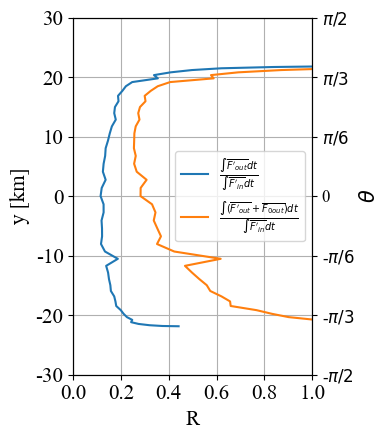

In [185]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4.5))

ax.plot(R_bc[25:-25,0],y_circles[25:-25,0], label=r"$\frac{\int\overline{F'_{out}}dt}{\int\overline{F'_{in}}dt}$")
ax.plot(R_all[25:-25,0],y_circles[25:-25,0], label=r"$\frac{\int(\overline{F'_{out}}+\overline{F_{0out}})dt}{\int\overline{F'_{in}}dt}$")
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1+1e-4,.2))
ax.set_ylim([y_circles[25,0], y_circles[-25,0]])
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])

ax.set_xlabel('R', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True)

ax2 = ax.twinx()
ax2.set_ylim([theta_circles[25], theta_circles[-26]])
ax2.set_yticks(np.arange(theta_circles[25], theta_circles[-26]+1e-4,np.pi/6))
ax2.set_yticklabels(['-$\pi/2$', '-$\pi/3$', '-$\pi/6$', '0', '$\pi/6$', '$\pi/3$', '$\pi/2$'])
ax2.tick_params(axis='y', which='major', labelsize=12)
ax2.set_ylabel(r'$\theta$', fontsize=15)

plt.rcParams["font.family"] = "Times New Roman"
ax.legend(loc='center right')
# ax.legend(loc='upper right', bbox_to_anchor=(1, -.12), ncol=1, fontsize=12)
plt.tight_layout()

plt.savefig(outfilepath+ f"R_foot_of_island_summer_f.jpeg", dpi=300)

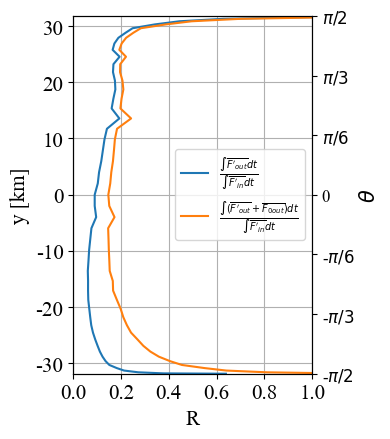

In [184]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4.5))

ax.plot(R_bc[25:-25,1],y_circles[25:-25,1], label=r"$\frac{\int\overline{F'_{out}}dt}{\int\overline{F'_{in}}dt}$")
ax.plot(R_all[25:-25,1],y_circles[25:-25,1], label=r"$\frac{\int(\overline{F'_{out}}+\overline{F_{0out}})dt}{\int\overline{F'_{in}}dt}$")
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1+1e-4,.2))
ax.set_ylim([y_circles[25,1], y_circles[-25,1]])
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])

ax.set_xlabel('R', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True)

ax2 = ax.twinx()
ax2.set_ylim([theta_circles[25], theta_circles[-26]])
ax2.set_yticks(np.arange(theta_circles[25], theta_circles[-26]+1e-4,np.pi/6))
ax2.set_yticklabels(['-$\pi/2$', '-$\pi/3$', '-$\pi/6$', '0', '$\pi/6$', '$\pi/3$', '$\pi/2$'])
ax2.tick_params(axis='y', which='major', labelsize=12)
ax2.set_ylabel(r'$\theta$', fontsize=15)

plt.rcParams["font.family"] = "Times New Roman"
ax.legend(loc='center right')
# ax.legend(loc='upper right', bbox_to_anchor=(1, -.12), ncol=1, fontsize=12)
plt.tight_layout()

plt.savefig(outfilepath+ f"R_10km_away_island_summer_f.jpeg", dpi=300)

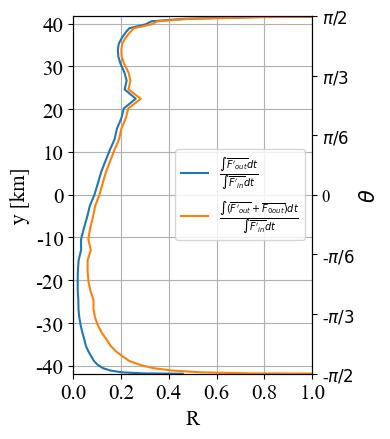

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4.5))

ax.plot(R_bc[25:-25,-1],y_circles[25:-25,-1], label=r"$\frac{\int\overline{F'_{out}}dt}{\int\overline{F'_{in}}dt}$")
ax.plot(R_all[25:-25,-1],y_circles[25:-25,-1], label=r"$\frac{\int(\overline{F'_{out}}+\overline{F_{0out}})dt}{\int\overline{F'_{in}}dt}$")
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1+1e-4,.2))
ax.set_ylim([y_circles[25,-1], y_circles[-25,-1]])
ax.set_yticks(np.arange(y_c-40000,y_c+40000+1,10000))
ax.set_yticklabels(['-40', '-30', '-20', '-10', '0', '10', '20', '30', '40'])

ax.set_xlabel('R', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True)

ax2 = ax.twinx()
ax2.set_ylim([theta_circles[25], theta_circles[-26]])
ax2.set_yticks(np.arange(theta_circles[25], theta_circles[-26]+1e-4,np.pi/6))
ax2.set_yticklabels(['-$\pi/2$', '-$\pi/3$', '-$\pi/6$', '0', '$\pi/6$', '$\pi/3$', '$\pi/2$'])
ax2.tick_params(axis='y', which='major', labelsize=12)
ax2.set_ylabel(r'$\theta$', fontsize=15)

plt.rcParams["font.family"] = "Times New Roman"
ax.legend(loc='center right')
# ax.legend(loc='upper right', bbox_to_anchor=(1, -.12), ncol=1, fontsize=12)
plt.tight_layout()

plt.savefig(outfilepath+ f"R_20km_away_island_summer_f.jpeg", dpi=300)

## theory from Bourgault and Kelley (2007)
$R = 1-e^{-I_r/0.78}$

In [190]:
Ir = 0.55
R_BK07 = 1-np.exp(-Ir/.78)
R_BK07

0.5059547689364203